In [84]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords 
import re
import string 
import nltk
import os
# from wordcloud import WordCloud
nltk.download("stopwords")
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, recall_score, f1_score
from lightgbm import LGBMClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam


[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [85]:
df = pd.read_json("../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.shape

(28619, 3)

In [86]:
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [87]:
df.tail()

,is_sarcastic,headline,article_link
28614,1,jews to celebrate rosh hashasha or something,https://www.theonion.com/jews-to-celebrate-ros...
28615,1,internal affairs investigator disappointed con...,https://local.theonion.com/internal-affairs-in...
28616,0,the most beautiful acceptance speech this week...,https://www.huffingtonpost.com/entry/andrew-ah...
28617,1,mars probe destroyed by orbiting spielberg-gat...,https://www.theonion.com/mars-probe-destroyed-...
28618,1,dad clarifies this not a food stop,https://www.theonion.com/dad-clarifies-this-no...


In [88]:
df.sample(5)

,is_sarcastic,headline,article_link
13144,0,world meets premiere,https://www.huffingtonpost.com/entry/girl-meet...
19826,1,buoyant force on area object equal to weight o...,https://local.theonion.com/buoyant-force-on-ar...
19598,0,ellen responds to las vegas massacre in most b...,https://www.huffingtonpost.com/entry/ellen-las...
24313,0,prejudice does not discriminate,https://www.huffingtonpost.com/entry/prejudice...
5644,1,having awkward conversation with coworkers in ...,https://www.theonion.com/having-awkward-conver...


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [90]:
df.isna().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [91]:
df.duplicated().sum()

2

In [92]:
df.drop_duplicates(keep='first', inplace=True)

In [93]:
df.duplicated().sum()

0

In [94]:
del df['article_link']

In [95]:
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [96]:
df.describe()

,is_sarcastic
count,28617.000000
mean,0.476395
std,0.499451
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [97]:
df.describe(include="O")

,headline
count,28617
unique,28503
top,"'no way to prevent this,' says only nation whe..."
freq,12


is_sarcastic
0    14984
1    13633
Name: count, dtype: int64 



([<matplotlib.patches.Wedge at 0x789343253d30>,
 [Text(-0.0814978302321584, 1.096976801790927, '0'),
  Text(0.08149793293853813, -1.0969767941605446, '1')],
 [Text(-0.04445336194481366, 0.598350982795051, '52.4%'),
  Text(0.04445341796647534, -0.5983509786330242, '47.6%')])

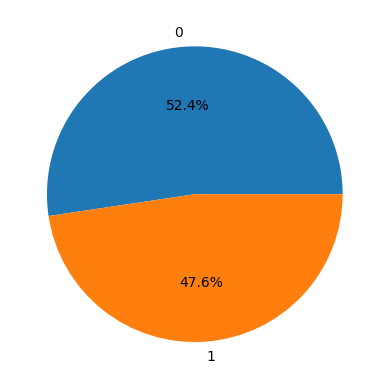

In [98]:
print(df.is_sarcastic.value_counts() ,"\n")
plt.pie(df["is_sarcastic"].value_counts().values,explode=[0,0],labels=df.is_sarcastic.value_counts().index, autopct='%1.1f%%')

In [99]:
def clean_text(sentences): 
    # convert text to lowercase 
    text = sentences.lower() 
    # remove text in square brackets 
    text = re.sub('\[.*?\]', '', text) 
    # removing punctuations 
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) 
    # removing words containing digits 
    text = re.sub('\w*\d\w*', '', text) 
    # Join the words 
    text = ' '.join([word for word in text.split() 
                     if word not in stopwords.words('english')]) 
    return text 

In [100]:
df['cleaned_headline']=df['headline'].map(clean_text)

In [101]:
df.head()

,is_sarcastic,headline,cleaned_headline
0,1,thirtysomething scientists unveil doomsday clo...,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...,dem rep totally nails congress falling short g...
2,0,eat your veggies: 9 deliciously different recipes,eat veggies deliciously different recipes
3,1,inclement weather prevents liar from getting t...,inclement weather prevents liar getting work
4,1,mother comes pretty close to using word 'strea...,mother comes pretty close using word streaming...


In [102]:
x_train,x_test,y_train,y_test = train_test_split(df.cleaned_headline,df.is_sarcastic, test_size = 0.3 , random_state = 42)

In [103]:
max_features = 40000
maxlen = 200

In [104]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(tokenized_train, maxlen=maxlen)

In [105]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(tokenized_test, maxlen=maxlen)

In [106]:
embeddings_index = {}
embedding_dim = 100

embedding_dict={}
with open('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        coef=np.asarray(values[1:],'float32')
        embeddings_index[word]=coef
f.close()
print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


In [107]:
word_index=tokenizer.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 24019


In [108]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print(c)

21386


In [109]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=False)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [110]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print('Summary of the built model...')
print(model.summary())

Summary of the built model...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     2,402,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,402,000 (9.16 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,402,000 (9.16 MB)

None


In [111]:
history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test), verbose=2)

Epoch 1/10
157/157 - 43s - 272ms/step - acc: 0.6742 - loss: 0.5974 - val_acc: 0.7180 - val_loss: 0.5499
Epoch 2/10
157/157 - 39s - 248ms/step - acc: 0.7293 - loss: 0.5387 - val_acc: 0.7328 - val_loss: 0.5281
Epoch 3/10
157/157 - 40s - 253ms/step - acc: 0.7481 - loss: 0.5109 - val_acc: 0.7498 - val_loss: 0.5036
Epoch 4/10
157/157 - 40s - 255ms/step - acc: 0.7641 - loss: 0.4872 - val_acc: 0.7655 - val_loss: 0.4832
Epoch 5/10
157/157 - 39s - 246ms/step - acc: 0.7762 - loss: 0.4683 - val_acc: 0.7704 - val_loss: 0.4741
Epoch 6/10
157/157 - 39s - 245ms/step - acc: 0.7866 - loss: 0.4520 - val_acc: 0.7717 - val_loss: 0.4702
Epoch 7/10
157/157 - 39s - 247ms/step - acc: 0.7914 - loss: 0.4407 - val_acc: 0.7767 - val_loss: 0.4620
Epoch 8/10
157/157 - 39s - 248ms/step - acc: 0.7974 - loss: 0.4318 - val_acc: 0.7837 - val_loss: 0.4516
Epoch 9/10
157/157 - 41s - 263ms/step - acc: 0.8095 - loss: 0.4162 - val_acc: 0.7848 - val_loss: 0.4478
Epoch 10/10
157/157 - 41s - 262ms/step - acc: 0.8132 - loss: 0.4

In [112]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

269/269 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - acc: 0.7937 - loss: 0.4300
Accuracy of the model on Testing Data is -  78.69787812232971
